# Q3 2024 Bike-Rides Analysis

**Objective:**  
- Load and clean raw trips data  
- Compute ride durations and weekday features  
- Summarize usage patterns by day, hour, and user type  
- Visualize key metrics

In [2]:
# ─── PARAMETERS & SETUP ─────────────────────────────────────────────────────────
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

#  Change these values for any quarter:
YEAR    = 2024      # calendar year
QUARTER = 3         # 1=Jan–Mar, 2=Apr–Jun, 3=Jul–Sep, 4=Oct–Dec

#  Compute our date bounds and file‐glob:
Q_START = f"{YEAR}-{3*(QUARTER-1)+1:02d}-01"   # e.g. '2024-07-01' for Q3
Q_END   = f"{YEAR}-{3*QUARTER+1:02d}-01"       # e.g. '2024-10-01' for Q3
GLOB    = f"data/{YEAR}_Q{QUARTER}_csv/*.csv"  # e.g. 'data/2024_Q3_csv/*.csv'

#  Connect (or create) DuckDB DB file
DB_PATH = f"rides_{YEAR}_q{QUARTER}.db"
con     = duckdb.connect(DB_PATH)

print(f"Parameters → YEAR={YEAR}, QUARTER={QUARTER}")
print("Loading CSVs from:", GLOB)

Parameters → YEAR=2024, QUARTER=3
Loading CSVs from: data/2024_Q3_csv/*.csv


In [3]:
# Ingest all CSVs into a raw view
con.execute(f"""
CREATE OR REPLACE VIEW raw_data_q{QUARTER} AS
SELECT * 
FROM read_csv_auto('{GLOB}');
""")
raw_count = con.execute(f"SELECT COUNT(*) FROM raw_data_q{QUARTER}").fetchone()[0]
print("Raw rows:", raw_count)


Raw rows: 2325877


In [4]:
# Add ride_length and day_of_week
con.execute(f"""
CREATE OR REPLACE VIEW data_q{QUARTER} AS
SELECT
  *,
  ended_at - started_at                           AS ride_length,
  CAST(EXTRACT(dow FROM started_at) AS INTEGER)+1  AS day_of_week
FROM raw_data_q{QUARTER};
""")
trans_count = con.execute(f"SELECT COUNT(*) FROM data_q{QUARTER}").fetchone()[0]
print("Transformed rows:", trans_count)


Transformed rows: 2325877


In [5]:
# Build cleaned_q3 with ONLY rides that start in Q3 (July–Sept)
con.execute(f"""
DROP TABLE IF EXISTS cleaned_q{QUARTER};

CREATE TABLE cleaned_q{QUARTER} AS
SELECT DISTINCT
    ride_id,
    rideable_type,
    started_at,
    ended_at,
    start_station_id,
    end_station_id,
    ROUND(start_lat,4) AS start_lat,
    ROUND(start_lng,4) AS start_lng,
    ROUND(end_lat,4)   AS end_lat,
    ROUND(end_lng,4)   AS end_lng,
    member_casual,
    ended_at - started_at       AS ride_length,
    CAST(EXTRACT(dow FROM started_at) AS INTEGER)+1 AS day_of_week
FROM data_q{QUARTER}
WHERE
    ride_id IS NOT NULL
    AND started_at >= DATE '{Q_START}'
    AND started_at <  DATE '{Q_END}'
    AND ended_at IS NOT NULL
    AND start_lat IS NOT NULL
    AND start_lng IS NOT NULL
    AND end_lat IS NOT NULL
    AND end_lng IS NOT NULL
    AND (ended_at - started_at)
        BETWEEN INTERVAL '1 minute' AND INTERVAL '24 hours';
""")
cleaned_count = con.execute(f"SELECT COUNT(*) FROM cleaned_q{QUARTER}").fetchone()[0]
print("Cleaned rows:", cleaned_count)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Cleaned rows: 2269044


In [ ]:
# QUALITY CHECKS 
# No nulls in required columns
nulls = con.execute(f"""
  SELECT 
    SUM(CASE WHEN ride_id IS NULL THEN 1 ELSE 0 END)       AS ride_id_nulls,
    SUM(CASE WHEN start_lat IS NULL THEN 1 ELSE 0 END)     AS start_lat_nulls,
    SUM(CASE WHEN ride_length < INTERVAL '0' THEN 1 ELSE 0 END) AS negative_durations
  FROM cleaned_q{QUARTER}
""").df()
display(nulls)

assert nulls.iloc[0].sum() == 0, "Found unexpected nulls or negative durations!"
print("Quality checks passed: no nulls, no negative durations")

In [6]:
# ─── CREATE DAILY RIDES VIEW ───────────────────────────────────────────────────
con.execute(f"""
CREATE OR REPLACE VIEW rides_per_day_q{QUARTER} AS
SELECT
  DATE(started_at)                     AS ride_date,
  COUNT(*)                             AS total_rides,
  AVG(EXTRACT(epoch FROM ride_length))/60.0 AS avg_duration_min
FROM cleaned_q{QUARTER}
GROUP BY ride_date
ORDER BY ride_date;
""")


In [7]:
# ─── CREATE HOURLY RIDES VIEW ──────────────────────────────────────────────────
con.execute(f"""
CREATE OR REPLACE VIEW rides_by_hour_q{QUARTER} AS
SELECT
  EXTRACT(hour FROM started_at) AS hour_of_day,
  COUNT(*)                     AS ride_count
FROM cleaned_q{QUARTER}
GROUP BY hour_of_day
ORDER BY hour_of_day;
""")

<Figure size 640x480 with 0 Axes>

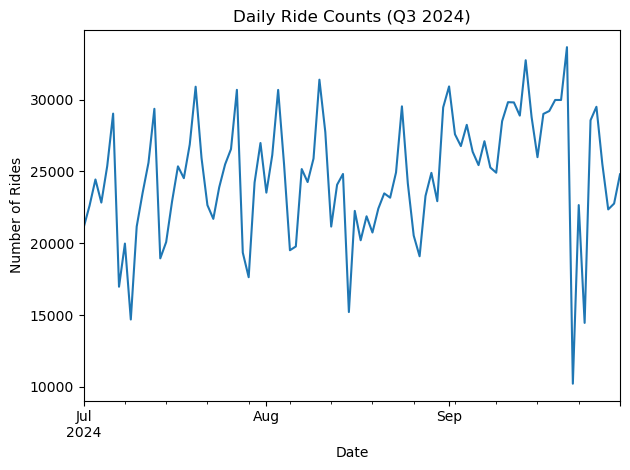

In [8]:
# ─── PLOT: DAILY RIDES ─────────────────────────────────────────────────────────
df_day = con.execute(f"SELECT * FROM rides_per_day_q{QUARTER}").df()
plt.figure()
df_day.plot(x='ride_date', y='total_rides', legend=False)
plt.title(f"Daily Ride Counts (Q{QUARTER} {YEAR})")
plt.xlabel("Date")
plt.ylabel("Number of Rides")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

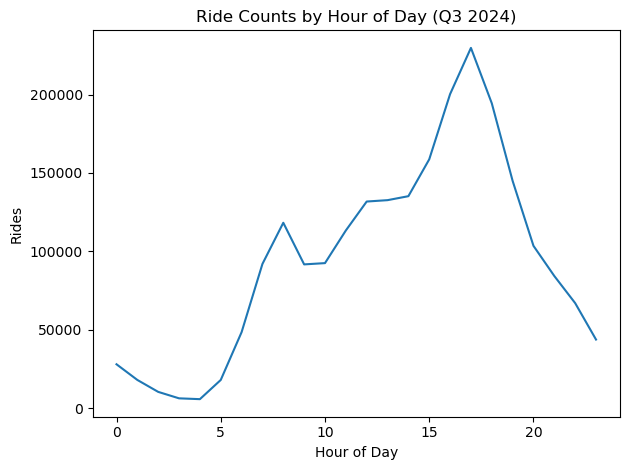

In [9]:
# ─── PLOT: HOURLY RIDES ────────────────────────────────────────────────────────
df_hour = con.execute(f"SELECT * FROM rides_by_hour_q{QUARTER}").df()
plt.figure()
df_hour.plot(x='hour_of_day', y='ride_count', legend=False)
plt.title(f"Ride Counts by Hour of Day (Q{QUARTER} {YEAR})")
plt.xlabel("Hour of Day")
plt.ylabel("Rides")
plt.tight_layout()
plt.show()

In [10]:
# ─── MONTHLY METRICS (mean, max, mode day) ────────────────────────────────────
monthly_metrics = con.execute(f"""
WITH base AS (
  SELECT
    EXTRACT(month FROM started_at)::INT         AS month,
    EXTRACT(epoch FROM (ended_at - started_at)) AS duration_sec,
    day_of_week
  FROM cleaned_q{QUARTER}
)
SELECT
  month,
  ROUND(AVG(duration_sec)/60.0, 2) AS mean_duration_min,
  ROUND(MAX(duration_sec)/60.0,   2) AS max_duration_min,
  (
    SELECT day_of_week
    FROM (
      SELECT day_of_week, COUNT(*) AS cnt
      FROM base b2
      WHERE b2.month = b1.month
      GROUP BY day_of_week
      ORDER BY cnt DESC
      LIMIT 1
    )
  ) AS mode_day_of_week
FROM base b1
GROUP BY month
ORDER BY month;
""").df()
monthly_metrics

,month,mean_duration_min,max_duration_min,mode_day_of_week
0,7,17.89,1438.70,4
1,8,17.03,1438.65,7
2,9,15.11,1439.39,2


In [11]:
# ─── ADD HUMAN‐READABLE WEEKDAY ───────────────────────────────────────────────
weekday_map = {
    1: 'Sunday',  2: 'Monday',  3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday',6: 'Friday',  7: 'Saturday'
}

monthly_metrics['mode_day_name'] = (
    monthly_metrics['mode_day_of_week']
      .map(weekday_map)
)

# reorder columns for clarity
monthly_metrics = monthly_metrics[[
    'month',
    'mean_duration_min',
    'max_duration_min',
    'mode_day_of_week',
    'mode_day_name'
]]

monthly_metrics

,month,mean_duration_min,max_duration_min,mode_day_of_week,mode_day_name
0,7,17.89,1438.70,4,Wednesday
1,8,17.03,1438.65,7,Saturday
2,9,15.11,1439.39,2,Monday
